In [1]:
%reset -f

In [2]:
from datasets import load_dataset, DatasetDict
from transformers import ViTForImageClassification, ViTFeatureExtractor, DefaultDataCollator
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

dataset_dir = "/home/clap/Documents/miniproject_bioinformatic/dataset/dataset_beans_split/sample_150" #load from env parameter
beans_dataset = load_dataset("imagefolder", data_dir=dataset_dir)

/home/clap/Documents/www/bean-leaf-classification-transformer/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


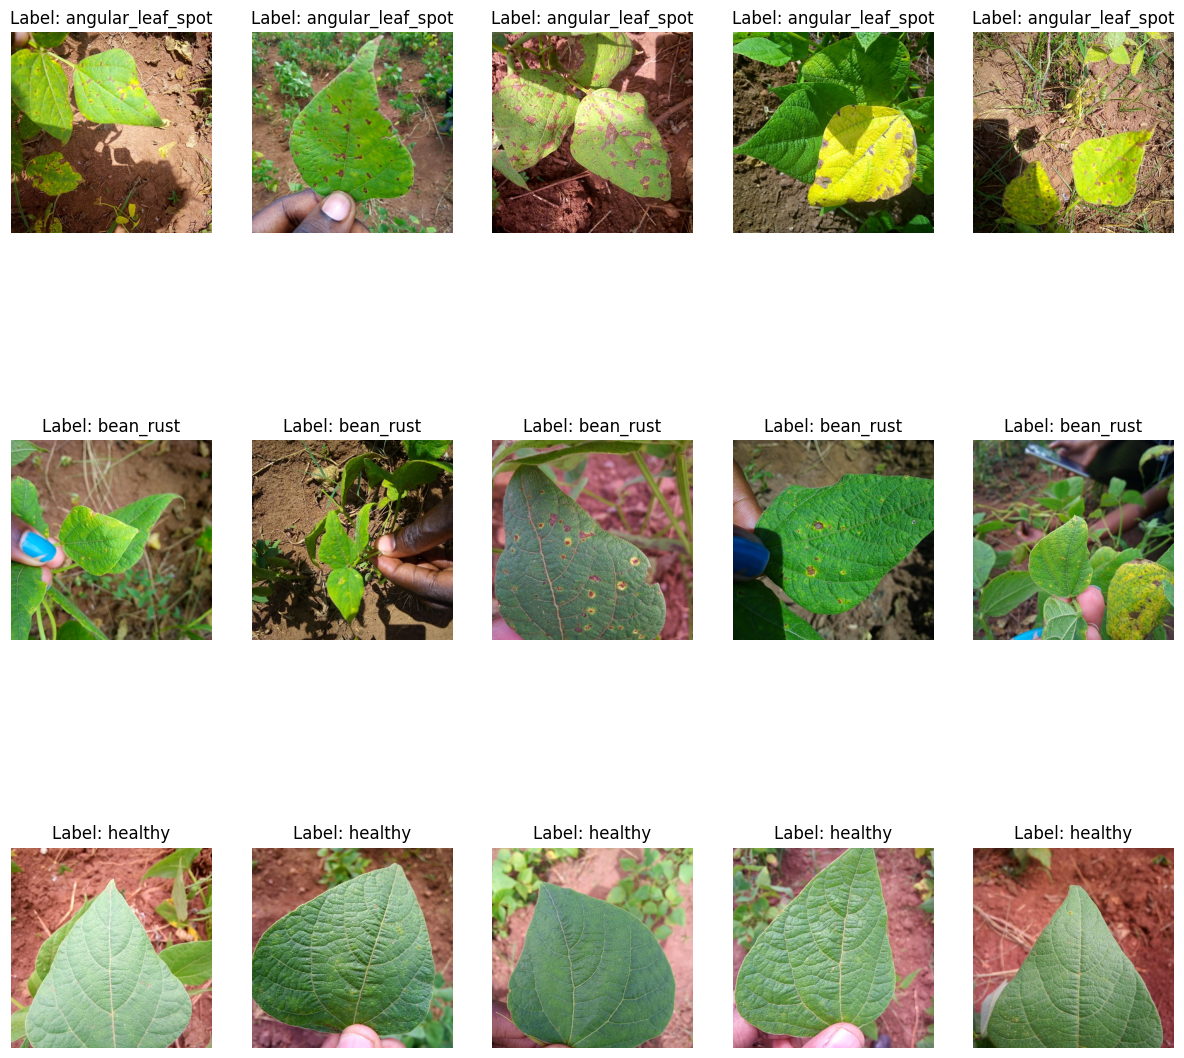

In [3]:
import matplotlib.pyplot as plt
# Function to display images with labels
def show_images_with_labels(dataset, num_images=5):
    ds_features = dataset.features
    fig, axes = plt.subplots(3, num_images, figsize=(15, 15))
    for index_label in range(3):
        label_dataset = dataset.filter(lambda example: example['label'] == index_label)
        for j, example in enumerate(label_dataset.select(range(num_images))):
            image = example['image']
            label = example['label']
            label = ds_features['label'].int2str(label)
            axes[index_label, j].imshow(image)
            axes[index_label, j].set_title(f"Label: {label}")
            axes[index_label, j].axis('off')
    plt.show()

show_images_with_labels(beans_dataset['train'])

In [4]:
# Preprocess data using ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

def preprocess_data(examples):
    # Extract pixel values and normalize images
    images = [image for image in examples["image"]]
    inputs = feature_extractor(images=images, return_tensors="np")
    examples["pixel_values"] = inputs["pixel_values"]
    return examples

# Apply preprocessing to train and test splits
beans_data = beans_dataset.map(preprocess_data, batched=True)

# Remove unused columns and set format for PyTorch
beans_data = beans_data.remove_columns(["image"])
beans_data.set_format("torch", columns=["pixel_values", "label"])



/home/clap/Documents/www/bean-leaf-classification-transformer/.venv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=3,  # Beans dataset has 3 classes
    id2label={0: "angular_leaf_spot", 1: "bean_rust", 2: "healthy"},
    label2id={"angular_leaf_spot": 0, "bean_rust": 1, "healthy": 2},
     ignore_mismatched_sizes=True  
)
# Define training arguments
training_args = TrainingArguments(
    output_dir="./vit-beans",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    logging_dir="./logs",
    logging_steps=10,
    num_train_epochs=20,

)


# Data collator for padding
data_collator = DefaultDataCollator()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/clap/Documents/www/bean-leaf-classification-transformer/.venv/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [6]:
# Define metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import EarlyStoppingCallback


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=beans_data["train"],
    eval_dataset=beans_data["validation"],
    tokenizer=feature_extractor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
   callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]  #
)

# Train the model
trainer.train()

# Evaluate on test set
test_results = trainer.evaluate(eval_dataset=beans_data["test"])
print(f"Test Results: {test_results}")

/tmp/ipykernel_192081/3063431320.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  5%|▌         | 10/200 [00:32<08:28,  2.68s/it]

{'loss': 0.9896, 'grad_norm': 12.935441970825195, 'learning_rate': 1.9e-05, 'epoch': 1.0}


                                                
  5%|▌         | 10/200 [00:42<08:28,  2.68s/it]

{'eval_loss': 0.736545979976654, 'eval_accuracy': 0.7443609022556391, 'eval_precision': 0.7463927101769999, 'eval_recall': 0.7443609022556391, 'eval_f1': 0.7430481180914433, 'eval_runtime': 9.5253, 'eval_samples_per_second': 13.963, 'eval_steps_per_second': 0.945, 'epoch': 1.0}


 10%|█         | 20/200 [01:14<08:22,  2.79s/it]

{'loss': 0.4418, 'grad_norm': 6.3541460037231445, 'learning_rate': 1.8e-05, 'epoch': 2.0}


                                                
 10%|█         | 20/200 [01:23<08:22,  2.79s/it]

{'eval_loss': 0.490596741437912, 'eval_accuracy': 0.8646616541353384, 'eval_precision': 0.87347962756942, 'eval_recall': 0.8646616541353384, 'eval_f1': 0.8656095654882632, 'eval_runtime': 9.5877, 'eval_samples_per_second': 13.872, 'eval_steps_per_second': 0.939, 'epoch': 2.0}


 15%|█▌        | 30/200 [01:57<08:21,  2.95s/it]

{'loss': 0.212, 'grad_norm': 6.310844421386719, 'learning_rate': 1.7e-05, 'epoch': 3.0}


                                                
 15%|█▌        | 30/200 [02:07<08:21,  2.95s/it]

{'eval_loss': 0.34791436791419983, 'eval_accuracy': 0.8796992481203008, 'eval_precision': 0.8866786766054304, 'eval_recall': 0.8796992481203008, 'eval_f1': 0.8813356921716055, 'eval_runtime': 9.9995, 'eval_samples_per_second': 13.301, 'eval_steps_per_second': 0.9, 'epoch': 3.0}


 20%|██        | 40/200 [02:43<08:23,  3.14s/it]

{'loss': 0.0873, 'grad_norm': 3.4654393196105957, 'learning_rate': 1.6000000000000003e-05, 'epoch': 4.0}


                                                
 20%|██        | 40/200 [02:54<08:23,  3.14s/it]

{'eval_loss': 0.2647404968738556, 'eval_accuracy': 0.8872180451127819, 'eval_precision': 0.8929466523451486, 'eval_recall': 0.8872180451127819, 'eval_f1': 0.8887388028715318, 'eval_runtime': 10.903, 'eval_samples_per_second': 12.198, 'eval_steps_per_second': 0.825, 'epoch': 4.0}


 25%|██▌       | 50/200 [03:30<07:54,  3.17s/it]

{'loss': 0.0308, 'grad_norm': 0.7476586103439331, 'learning_rate': 1.5000000000000002e-05, 'epoch': 5.0}


                                                
 25%|██▌       | 50/200 [03:40<07:54,  3.17s/it]

{'eval_loss': 0.23355865478515625, 'eval_accuracy': 0.9097744360902256, 'eval_precision': 0.9191956669613076, 'eval_recall': 0.9097744360902256, 'eval_f1': 0.9110208301093785, 'eval_runtime': 10.4925, 'eval_samples_per_second': 12.676, 'eval_steps_per_second': 0.858, 'epoch': 5.0}


 30%|███       | 60/200 [04:16<07:23,  3.17s/it]

{'loss': 0.0128, 'grad_norm': 0.16961809992790222, 'learning_rate': 1.4e-05, 'epoch': 6.0}


                                                
 30%|███       | 60/200 [04:27<07:23,  3.17s/it]

{'eval_loss': 0.18498806655406952, 'eval_accuracy': 0.924812030075188, 'eval_precision': 0.9286168382629046, 'eval_recall': 0.924812030075188, 'eval_f1': 0.9253142937262517, 'eval_runtime': 10.9061, 'eval_samples_per_second': 12.195, 'eval_steps_per_second': 0.825, 'epoch': 6.0}


 35%|███▌      | 70/200 [05:04<07:01,  3.24s/it]

{'loss': 0.0077, 'grad_norm': 0.23539243638515472, 'learning_rate': 1.3000000000000001e-05, 'epoch': 7.0}


                                                
 35%|███▌      | 70/200 [05:15<07:01,  3.24s/it]

{'eval_loss': 0.167276069521904, 'eval_accuracy': 0.924812030075188, 'eval_precision': 0.9263826093472886, 'eval_recall': 0.924812030075188, 'eval_f1': 0.9250744109413405, 'eval_runtime': 11.0991, 'eval_samples_per_second': 11.983, 'eval_steps_per_second': 0.811, 'epoch': 7.0}


 40%|████      | 80/200 [05:51<06:28,  3.24s/it]

{'loss': 0.0054, 'grad_norm': 0.1909775286912918, 'learning_rate': 1.2e-05, 'epoch': 8.0}


                                                
 40%|████      | 80/200 [06:02<06:28,  3.24s/it]

{'eval_loss': 0.16863945126533508, 'eval_accuracy': 0.924812030075188, 'eval_precision': 0.9286168382629046, 'eval_recall': 0.924812030075188, 'eval_f1': 0.9253142937262517, 'eval_runtime': 10.7586, 'eval_samples_per_second': 12.362, 'eval_steps_per_second': 0.837, 'epoch': 8.0}


 45%|████▌     | 90/200 [06:40<05:59,  3.27s/it]

{'loss': 0.0042, 'grad_norm': 0.13343560695648193, 'learning_rate': 1.1000000000000001e-05, 'epoch': 9.0}


                                                
 45%|████▌     | 90/200 [06:51<05:59,  3.27s/it]

{'eval_loss': 0.17224784195423126, 'eval_accuracy': 0.924812030075188, 'eval_precision': 0.9307882331366435, 'eval_recall': 0.924812030075188, 'eval_f1': 0.9258348076072533, 'eval_runtime': 11.0078, 'eval_samples_per_second': 12.082, 'eval_steps_per_second': 0.818, 'epoch': 9.0}


 50%|█████     | 100/200 [07:28<05:24,  3.25s/it]

{'loss': 0.0034, 'grad_norm': 0.07306427508592606, 'learning_rate': 1e-05, 'epoch': 10.0}


                                                 
 50%|█████     | 100/200 [07:39<05:24,  3.25s/it]

{'eval_loss': 0.1709786057472229, 'eval_accuracy': 0.924812030075188, 'eval_precision': 0.9307882331366435, 'eval_recall': 0.924812030075188, 'eval_f1': 0.9258348076072533, 'eval_runtime': 10.9762, 'eval_samples_per_second': 12.117, 'eval_steps_per_second': 0.82, 'epoch': 10.0}


 55%|█████▌    | 110/200 [08:15<04:46,  3.18s/it]

{'loss': 0.0031, 'grad_norm': 0.09276838600635529, 'learning_rate': 9e-06, 'epoch': 11.0}


                                                 
 55%|█████▌    | 110/200 [08:26<04:46,  3.18s/it]

{'eval_loss': 0.1673671305179596, 'eval_accuracy': 0.9323308270676691, 'eval_precision': 0.9368779090583602, 'eval_recall': 0.9323308270676691, 'eval_f1': 0.9331889735859557, 'eval_runtime': 10.8648, 'eval_samples_per_second': 12.241, 'eval_steps_per_second': 0.828, 'epoch': 11.0}


 55%|█████▌    | 110/200 [08:26<06:54,  4.61s/it]


{'train_runtime': 506.8655, 'train_samples_per_second': 5.879, 'train_steps_per_second': 0.395, 'train_loss': 0.16346969399601222, 'epoch': 11.0}


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]

Test Results: {'eval_loss': 0.2374090999364853, 'eval_accuracy': 0.90625, 'eval_precision': 0.9096765350877193, 'eval_recall': 0.90625, 'eval_f1': 0.9059585283543616, 'eval_runtime': 10.7973, 'eval_samples_per_second': 11.855, 'eval_steps_per_second': 0.741, 'epoch': 11.0}


In [7]:
from sklearn.metrics import precision_recall_fscore_support

# Run predictions on the test set
predictions = trainer.predict(beans_data["test"])

# Get the true labels and predicted labels
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

100%|██████████| 8/8 [00:08<00:00,  1.12s/it]

Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1 Score: 0.91


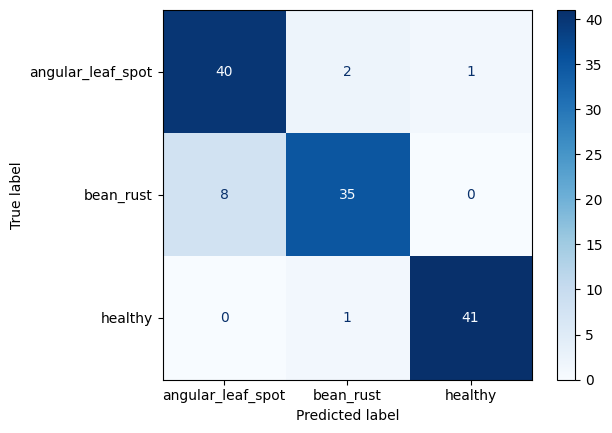

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt


# Get the true labels and predicted labels
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["angular_leaf_spot", "bean_rust", "healthy"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [9]:
print(model)


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe